In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
plt.style.use('dark_background')
import random
import copy
#from distutils.util import strtobool

from tqdm.notebook import tqdm

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Plots.plot_util as plot_util
import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.Plots.model_plot import ModelPlot

In [2]:
# data specifics
background_rms = .005  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size per axis
numpix = 60
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.05  # full width at half maximum of PSF  #0.8
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

# generate the coordinate grid and image properties (we only read out the relevant lines we need)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ = util.make_grid_with_coordtransform(numPix=numpix, 
                                    deltapix=deltaPix, center_ra=0, center_dec=0, subgrid_res=1, inverse=False)

kwargs_data = {'background_rms': background_rms,  # rms of background noise
               'exposure_time': exp_time,  # exposure time (or a map per pixel)
               'ra_at_xy_0': ra_at_xy_0,  # RA at (0,0) pixel
               'dec_at_xy_0': dec_at_xy_0,  # DEC at (0,0) pixel 
               'transform_pix2angle': Mpix2coord,  # matrix to translate shift in pixel in shift in relative RA/DEC (2x2 matrix). Make sure it's units are arcseconds or the angular units you want to model.
               'image_data': np.zeros((numpix, numpix))  # 2d data vector, here initialized with zeros as place holders that get's overwritten once a simulated image with noise is created.
              }

# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}

In [3]:
def make_graphs(name, sim_i, sim_r, sim_g):
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1) = plt.subplots(figsize=(8, 5), ncols=1)

    rgb = make_lupton_rgb(sim_i, sim_r, sim_g, Q=11., stretch=40.)
    ax1.set_title('Source(s)')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    original = ax1.imshow(rgb, aspect='equal')
   
    #sub_path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()
    

In [4]:
def Simulation(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_lens):
    lens_model_list = ['SIE', 'SHEAR']
    source_model_list = ['SERSIC_ELLIPSE']
    lens_light_model_list = ['SERSIC_ELLIPSE']
    
    lens_model_class = LensModel(lens_model_list)
    
    kwargs_source = [kwargs_source_mag_g]
    source_model_class = LightModel(source_model_list)
    kwargs_lens_light = [kwargs_lens_light_mag_g]
    lens_light_model_class = LightModel(lens_light_model_list)
    
    data_class = ImageData(**kwargs_data)
    psf_class = PSF(**kwargs_psf)
    #kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
    
    imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, 
                        source_model_class=source_model_class, lens_light_model_class=lens_light_model_class,
                        kwargs_numerics=kwargs_numerics)
    
    image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=kwargs_lens_light, kwargs_ps=None)
    
    poisson = image_util.add_poisson(image_model, exp_time=exp_time)
    bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
    image_real = image_model + poisson + bkg

    #cmap_string = 'gray'
    #cmap = plt.get_cmap(cmap_string)
    cmap = plt.cm.get_cmap("gray").copy()
    cmap.set_bad(color='k', alpha=1.)
    cmap.set_under('k')

    v_min = -4
    v_max = 1

    f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

    ax = axes
    im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
    #im = ax.matshow(image_real, origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.autoscale(False)

    plt.show()
    
    data_class.update_data(image_real)
    kwargs_data['image_data'] = image_real
    return(data_class, image_real)

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log10


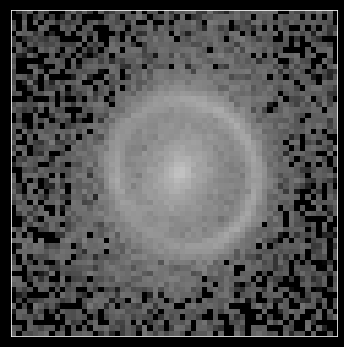

In [5]:
# lens light
kwargs_lens_light_mag_g = {'amp': 16, 'R_sersic': 0.6, 'n_sersic': 2, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.05, 'center_y': 0}
# source light
kwargs_source_mag_g  = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}

kwargs_spemd = {'theta_E': .66, 'center_x': 0.05, 'center_y': 0, 'e1': .07, 'e2': -0.03}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane
kwargs_lens = [kwargs_spemd, kwargs_shear]

data_class, image_real = Simulation(kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_lens)
data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

In [6]:
def Modeling(kwargs_model, kwargs_data):
    # lens models
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []

    fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
    kwargs_lens_init.append({'theta_E': 1., 'e1': 0., 'e2': 0.,
                             'center_x': 0., 'center_y': 0.})
    kwargs_lens_sigma.append({'theta_E': .2, 'e1': 0.05, 'e2': 0.05,
                             'center_x': 0.05, 'center_y': 0.05})
    kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_lens.append({'theta_E': 10., 'e1': 0.5, 'e2': 0.5, 'center_x': 10, 'center_y': 10})

    fixed_lens.append({'ra_0': 0, 'dec_0': 0})
    kwargs_lens_init.append({'gamma1': 0., 'gamma2': 0.0})
    kwargs_lens_sigma.append({'gamma1': 0.1, 'gamma2': 0.1})
    kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
    kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []


    fixed_source.append({})
    kwargs_source_init.append({'R_sersic': 0.2, 'n_sersic': 1, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0})
    kwargs_source_sigma.append({'n_sersic': 0.5, 'R_sersic': 0.1, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.2, 'center_y': 0.2})
    kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
    kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]


    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []


    fixed_lens_light.append({})
    kwargs_lens_light_init.append({'R_sersic': 0.5, 'n_sersic': 2, 'e1': 0, 'e2': 0, 'center_x': 0., 'center_y': 0})
    kwargs_lens_light_sigma.append({'n_sersic': 1, 'R_sersic': 0.3, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.1, 'center_y': 0.1})
    kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -5, 'center_y': -5})
    kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 5, 'center_y': 5})

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

    kwargs_params = {'lens_model': lens_params,
                    'source_model': source_params,
                    'lens_light_model': lens_light_params}

    kwargs_likelihood = {'source_marg': False}
    #kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list, 'lens_light_model_list': lens_light_model_list}

    multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
    # if you have multiple  bands to be modeled simultaneously, you can append them to the mutli_band_list
    kwargs_data_joint = {'multi_band_list': multi_band_list, 
                         'multi_band_type': 'multi-linear'  # 'multi-linear': every imaging band has independent solutions of the surface brightness, 'joint-linear': there is one joint solution of the linear coefficients demanded across the bands.
                        }
    kwargs_constraints = {}

    #from lenstronomy.Workflow.fitting_sequence import FittingSequence
    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [['PSO', {'sigma_scale': 15., 'n_particles': 300, 'n_iterations': 250}],
                       ['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10, 'sigma_scale': .1}]
        ]

    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    kwargs_result = fitting_seq.best_fit()
    
    modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    modelPlot.data_plot(ax=axes[0,0])
    modelPlot.model_plot(ax=axes[0,1])
    modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
    modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
    modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
    modelPlot.magnification_plot(ax=axes[1, 2])
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    
    return(kwargs_result)

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
Max iteration reached! Stopping.
-2.602912986043922 reduced X^2 of best position
-4657.912788525598 logL
3579 effective number of data points
[{'theta_E': 2.9541970502548893, 'e1': -0.39411028753826394, 'e2': -0.4845968106826722, 'center_x': -0.32142493939807265, 'center_y': -0.6791741197274134}, {'gamma1': -0.19997555336348458, 'gamma2': 0.19999942632347356, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.34820597086647054, 'n_sersic': 0.5005259719418296, 'e1': 0.4999922399392466, 'e2': -0.4999688061330014, 'center_x': -2.135454811451486, 'center_y': -1.5184081212126805}] source result
[{'amp': 1, 'R_sersic': 0.6294467272667118, 'n_sersic': 1.5236146189652746, 'e1': -0.05872018282485504, 'e2': 0.0898641420004692, 'center_x': 0.02469924560062277, 'center_y': -0.008462268830677123}] lens light result
[] point source result
{} special param result
65.988382339477

100%|█████████████████████████████████████████████████████████████████████████████████████████| 800/800 [00:14<00:00, 55.85it/s]
/Users/jimenagonzalez/.local/lib/python3.7/site-packages/lenstronomy-1.9.1-py3.7.egg/lenstronomy/Plots/plot_util.py:218: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gist_heat").copy()
  cmap.set_bad(color='k', alpha=1.)
/Users/jimenagonzalez/.local/lib/python3.7/site-packages/lenstronomy-1.9.1-py3.7.egg/lenstronomy/Plots/plot_util.py:219: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl

Computing the MCMC...
Number of walkers =  190
Burn-in iterations:  200
Sampling iterations (in current run): 800
14.38562798500061 time taken for MCMC sampling
-2.59975385037506 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  2.59975385037506


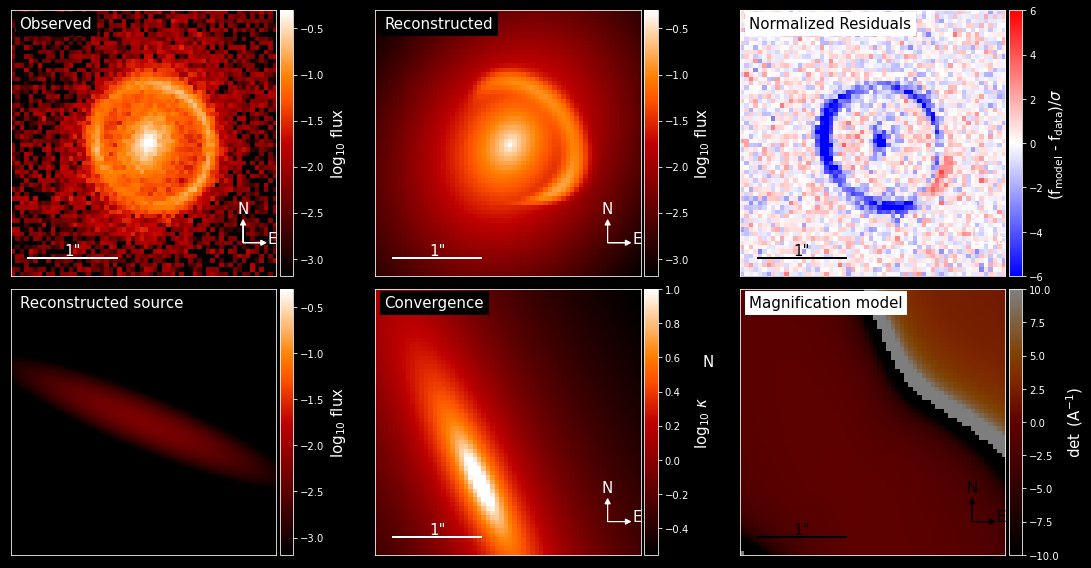

{'kwargs_lens': [{'theta_E': 2.9620682183336893, 'e1': -0.3970119894496694, 'e2': -0.4852116973358466, 'center_x': -0.3200398871260593, 'center_y': -0.6759913962576752}, {'gamma1': -0.1989324740606522, 'gamma2': 0.19938501140043785, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 26.869541891639802, 'R_sersic': 0.34503903376434647, 'n_sersic': 0.5228599151827279, 'e1': 0.4999640522848915, 'e2': -0.4996138299868654, 'center_x': -2.135020033463082, 'center_y': -1.5193993307964757}], 'kwargs_lens_light': [{'amp': 15.81532248142041, 'R_sersic': 0.6343967160426512, 'n_sersic': 1.5628805050011312, 'e1': -0.06284361584140222, 'e2': 0.09331098469578847, 'center_x': 0.024103853600924815, 'center_y': -0.01612277398349825}], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [7]:
kwargs_model = {'lens_model_list': ['SIE', 'SHEAR'],  # list of lens models to be used
                    'lens_light_model_list': ['SERSIC_ELLIPSE'],  # list of unlensed light models to be used
                'source_light_model_list': ['SERSIC_ELLIPSE'],  # list of extended source models to be used
                #'point_source_model_list': ['SOURCE_POSITION']  # list of point source models to be used
    }
kwargs_result = Modeling(kwargs_model, kwargs_data)
print(kwargs_result)